# Prepare Predictors from Corpus

This notebook processes the large corpus text file to extract word frequencies and prepare predictor data for analysis. The output will be used by `notebook2_corpus_analysis.ipynb` to compare different frequency measures.

In [8]:
import pandas as pd
import re
from collections import Counter
import os
import numpy as np

# File paths
corpus_file_path = '../output/large_corpus.txt'
output_csv_path = '../output/generated_corpus_with_predictors.csv'

print("Starting corpus processing...")
print(f"Corpus file: {corpus_file_path}")
print(f"Output file: {output_csv_path}")

Starting corpus processing...
Corpus file: ../output/large_corpus.txt
Output file: ../output/generated_corpus_with_predictors.csv


In [9]:
# Check if corpus file exists
if not os.path.exists(corpus_file_path):
    print(f"ERROR: Corpus file not found at {corpus_file_path}")
    print("Please ensure the large_corpus.txt file exists in the output directory.")
else:
    print("✓ Corpus file found")
    
    # Read the corpus
    print("Reading corpus...")
    with open(corpus_file_path, 'r', encoding='utf-8') as f:
        corpus_text = f.read()
    
    print(f"Corpus loaded: {len(corpus_text):,} characters")
    print(f"First 200 characters: {corpus_text[:200]}...")

✓ Corpus file found
Reading corpus...
Corpus loaded: 10,693,407 characters
First 200 characters: **How to Create a Reliable Backup System for Your Digital Life**

In today’s digital world, our lives are increasingly stored on computers, smartphones, and cloud services. From family photos and impo...


In [10]:
# Text preprocessing and tokenization
print("Cleaning and tokenizing text...")

# Remove metadata comments before processing
# The DOTALL flag is crucial for multiline JSON
cleaned_text = re.sub(r'<!-- Story Metadata:.*?-->', '', corpus_text, flags=re.DOTALL)

# Convert to lowercase and extract words using regex
# This pattern matches sequences of letters and some common contractions
words = re.findall(r"\b[a-z]+(?:'[a-z]+)?\b", cleaned_text.lower())

print(f"Total tokens extracted: {len(words):,}")
print(f"Sample tokens: {words[:20]}")

# Count word frequencies
print("Counting word frequencies...")
word_counts = Counter(words)
total_words = len(words)
unique_words = len(word_counts)

print(f"Unique words: {unique_words:,}")
print(f"Most common words: {word_counts.most_common(10)}")

Cleaning and tokenizing text...
Total tokens extracted: 1,337,011
Sample tokens: ['how', 'to', 'create', 'a', 'reliable', 'backup', 'system', 'for', 'your', 'digital', 'life', 'in', 'today', 's', 'digital', 'world', 'our', 'lives', 'are', 'increasingly']
Counting word frequencies...
Unique words: 38,427
Most common words: [('the', 73916), ('a', 56027), ('and', 29002), ('of', 28267), ('to', 22563), ('in', 22028), ('it', 21348), ('s', 18357), ('like', 11614), ('that', 10669)]


In [15]:
# Create DataFrame with word frequency data
print("Creating DataFrame...")

# Convert word counts to DataFrame
df_words = pd.DataFrame(word_counts.items(), columns=['word', 'llm_frequency_raw'])
df_words['word_length'] = df_words['word'].apply(len)

print(f"DataFrame created with {len(df_words)} words.")

# --- Data Integration ---
print("\nIntegrating with ECP reference data...")
try:
    ecp_df = pd.read_csv('../data/lexicaldecision/ecp/English Crowdsourcing Project All Native Speakers.csv')
    print(f"✅ Loaded {len(ecp_df)} records from ECP dataset")
    
    # Define word column and predictors to merge
    word_col = 'spelling' if 'spelling' in ecp_df.columns else 'Word'
    ref_cols = ['SUBTLEX', 'Multilex', 'GPT']
    cols_to_merge = [word_col] + [col for col in ref_cols if col in ecp_df.columns]
    
    # Merge generated frequencies with reference data
    merged_df = pd.merge(df_words, ecp_df[cols_to_merge], left_on='word', right_on=word_col, how='left')
    
    # Rename columns for clarity
    merged_df = merged_df.rename(columns={
        'SUBTLEX': 'subtlex_zipf',
        'Multilex': 'multilex_zipf',
        'GPT': 'gpt_familiarity'
    })
    if word_col != 'word':
        merged_df = merged_df.drop(columns=[word_col])
        
    print("✅ Merged generated data with ECP reference measures.")
    
except FileNotFoundError:
    print("⚠️ ECP data not found. Proceeding without reference measures.")
    merged_df = df_words.copy()

# --- Logarithmic Transformations ---
print("\nApplying logarithmic transformations...")

# Van Heuven et al. (2014) Zipf Scale
# log10( (frequency + 1) / (total_tokens_in_millions + total_types_in_millions) ) + 3
# Simplified for external corpora: log10(frequency_per_million + 1)
total_tokens_million = total_words / 1_000_000
print(f"Total tokens (millions): {total_tokens_million:.2f}")

def van_heuven_zipf(freq_series):
    # Assuming the input is already frequency per million for SUBTLEX/Multilex
    return np.log10(freq_series + 1)

def schepens_log(freq_series, corpus_size):
    """log( ( (1 + freq) * 1e6) / corpus_size )"""
    return np.log((1 + freq_series) * 1_000_000 / corpus_size)

# Apply transformations
merged_df['llm_freq_schepens'] = schepens_log(merged_df['llm_frequency_raw'], total_words)
print("   ✓ Calculated Schepens log for LLM frequency")

# For reference corpora, we assume they are already in a comparable scale (e.g., Zipf)
# We will apply a simple log10 transform for consistency in modeling
if 'subtlex_zipf' in merged_df.columns:
    merged_df['subtlex_log10'] = np.log10(merged_df['subtlex_zipf'] + 1)
    print("   ✓ Calculated log10 for SUBTLEX")
if 'multilex_zipf' in merged_df.columns:
    merged_df['multilex_log10'] = np.log10(merged_df['multilex_zipf'] + 1)
    print("   ✓ Calculated log10 for Multilex")
if 'gpt_familiarity' in merged_df.columns:
    # Familiarity is not a frequency, but log transform can help normalize it
    merged_df['gpt_familiarity_log10'] = np.log10(merged_df['gpt_familiarity'] + 1)
    print("   ✓ Calculated log10 for GPT Familiarity")

# Sort by raw frequency
merged_df = merged_df.sort_values('llm_frequency_raw', ascending=False).reset_index(drop=True)

print("\n✅ Transformations complete.")
print("\nFirst 10 rows of the processed data:")
display_cols = ['word', 'llm_frequency_raw', 'llm_freq_schepens', 'subtlex_zipf', 'gpt_familiarity']
available_cols = [col for col in display_cols if col in merged_df.columns]
print(merged_df[available_cols].head(10))

Creating DataFrame...
DataFrame created with 38427 words.

Integrating with ECP reference data...
✅ Loaded 61851 records from ECP dataset
✅ Merged generated data with ECP reference measures.

Applying logarithmic transformations...
Total tokens (millions): 1.34
   ✓ Calculated Schepens log for LLM frequency
   ✓ Calculated log10 for SUBTLEX
   ✓ Calculated log10 for Multilex
   ✓ Calculated log10 for GPT Familiarity

✅ Transformations complete.

First 10 rows of the processed data:
   word  llm_frequency_raw  llm_freq_schepens  subtlex_zipf  gpt_familiarity
0   the              73916          10.920262      7.468478         7.000000
1     a              56027          10.643170      7.309360         6.999306
2   and              29002           9.984718      7.126116         7.000000
3    of              28267           9.959049      7.063010         6.999999
4    to              22563           9.733674      7.355006         6.999999
5    in              22028           9.709679      

In [16]:
# --- Save Processed Data ---
output_path = '../output/merged_predictors.csv'
merged_df.to_csv(output_path, index=False)
print(f"\n✅ Processed data saved to {output_path}")


✅ Processed data saved to ../output/merged_predictors.csv


In [12]:
# Data quality checks and filtering
print("Applying data quality filters...")

# Filter out very short words (less than 2 characters) and very long words (more than 20 characters)
# This helps remove noise and focus on meaningful words
original_count = len(df_words)
df_words = df_words[(df_words['word_length'] >= 2) & (df_words['word_length'] <= 20)]
filtered_count = len(df_words)

print(f"Filtered from {original_count:,} to {filtered_count:,} words")
print(f"Removed {original_count - filtered_count:,} words due to length constraints")

# Filter out words that appear only once (hapax legomena) as they're often noise
df_words = df_words[df_words['frequency'] > 1]
final_count = len(df_words)

print(f"After removing hapax legomena: {final_count:,} words")
print(f"Removed {filtered_count - final_count:,} words that appeared only once")

print("\nFinal dataset statistics:")
print(f"Word frequency range: {df_words['frequency'].min()} - {df_words['frequency'].max()}")
print(f"Word length range: {df_words['word_length'].min()} - {df_words['word_length'].max()}")
print(f"Most frequent words: {df_words.head(5)['word'].tolist()}")

Applying data quality filters...
Filtered from 38,427 to 38,397 words
Removed 30 words due to length constraints
After removing hapax legomena: 27,047 words
Removed 11,350 words that appeared only once

Final dataset statistics:
Word frequency range: 2 - 73916
Word length range: 2 - 20
Most frequent words: ['the', 'and', 'of', 'to', 'in']


In [13]:
# Save the processed data to CSV
print("Saving data to CSV...")

# Ensure output directory exists
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Save to CSV
df_words.to_csv(output_csv_path, index=False)

print(f"✓ Data saved to: {output_csv_path}")
print(f"✓ Ready for analysis in notebook2_corpus_analysis.ipynb")

# Display summary information
print(f"\nSUMMARY:")
print(f"- Processed corpus: {len(corpus_text):,} characters")
print(f"- Total tokens: {total_words:,}")
print(f"- Unique words (after filtering): {len(df_words):,}")
print(f"- Output file: {output_csv_path}")
print(f"- Columns: {list(df_words.columns)}")

# Show a sample of the final data
print(f"\nSample of final data:")
print(df_words.head(15))

Saving data to CSV...
✓ Data saved to: ../output/generated_corpus_with_predictors.csv
✓ Ready for analysis in notebook2_corpus_analysis.ipynb

SUMMARY:
- Processed corpus: 10,693,407 characters
- Total tokens: 1,337,011
- Unique words (after filtering): 27,047
- Output file: ../output/generated_corpus_with_predictors.csv
- Columns: ['word', 'frequency', 'log_frequency', 'relative_frequency', 'word_length', 'frequency_rank']

Sample of final data:
    word  frequency  log_frequency  relative_frequency  word_length  \
0    the      73916       4.868738            0.055285            3   
2    and      29002       4.462428            0.021692            3   
3     of      28267       4.451280            0.021142            2   
4     to      22563       4.353397            0.016876            2   
5     in      22028       4.342975            0.016476            2   
6     it      21348       4.329357            0.015967            2   
8   like      11614       4.064982            0.0086

Creating basic frequency distribution plots...


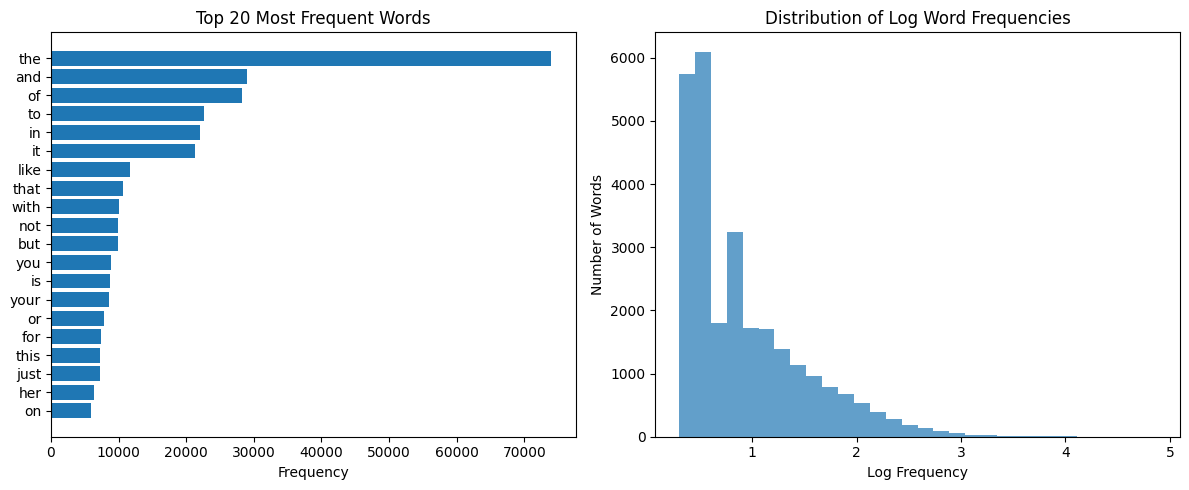

✓ Visualizations created


In [14]:
# Optional: Create basic visualizations
try:
    import matplotlib.pyplot as plt
    
    print("Creating basic frequency distribution plots...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Top 20 words
    top_20 = df_words.head(20)
    ax1.barh(range(len(top_20)), top_20['frequency'])
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels(top_20['word'])
    ax1.set_xlabel('Frequency')
    ax1.set_title('Top 20 Most Frequent Words')
    ax1.invert_yaxis()
    
    # Plot 2: Frequency distribution (log scale)
    ax2.hist(df_words['log_frequency'], bins=30, alpha=0.7)
    ax2.set_xlabel('Log Frequency')
    ax2.set_ylabel('Number of Words')
    ax2.set_title('Distribution of Log Word Frequencies')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations created")
    
except ImportError:
    print("Matplotlib not available - skipping visualizations")
    print("Install with: pip install matplotlib")